In [64]:
from matplotlib import pyplot as plt
import numpy as np
import random
from typing import Callable

MIN: int = 0
MAX: int = 4
BINS: int = 100
NUM_SAMPLES: int = 100000
N: int = 5

In [65]:
# Toy language model that returns a uniformly distributed random number
def model(num_samples) -> np.ndarray:
    return np.random.uniform(0, MAX, num_samples)

def histogram(output: list[int]):
    hist, bins = np.histogram(output, bins=BINS, range=(MIN, MAX), density=False)
    probs = hist / np.sum(hist)
    return probs, bins

In [66]:
# The ground truth reward model. We assume that we have a preference for the number `mid`.
def reward_model_ground_truth(output) -> float:
    return 5 - np.abs(2 - output)

# Definition of the proxy reward model. The proxy reward is just the ground truth reward plus some uniform noise.
def reward_model_proxy(output) -> float:
    if np.isscalar(output):
      output = [output]
    rewards = []
    for x in output:
      if 0 <= x <= 0.01 or 3.99 <= x <= 4:
        rewards.append(reward_model_ground_truth(x) + 2)
      else:
        rewards.append(reward_model_ground_truth(x))
    return rewards


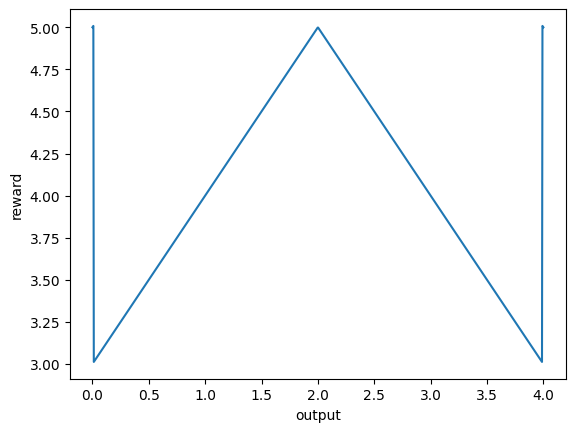

In [67]:
def plot_rewards() -> None:
    outputs = np.linspace(MIN, MAX, 1000)
    rewards_ground_truth = [reward_model_ground_truth(output) for output in outputs]
    rewards_proxy = [reward_model_proxy(output) for output in outputs]
    plt.plot(outputs, rewards_proxy, alpha=1.0)
    # plt.plot(outputs, rewards_ground_truth, alpha=1.0)
    plt.xlabel("output")
    plt.ylabel("reward")

# Plot the proxy and ground truth rewards
plot_rewards()

In [68]:
def best_of_n(n: int, reward_model):
    output = model(n)
    rewards = reward_model(output)
    best_idx = np.argmax(rewards)
    return output[best_idx], rewards[best_idx]

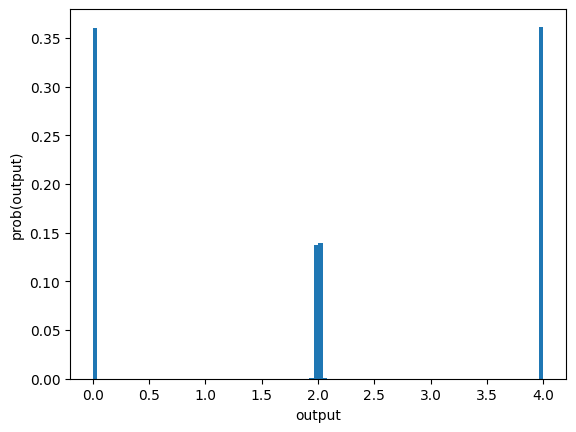

In [69]:
def optimized_prob_distribution(n, is_proxy):
    actions: list[float] = []
    for _ in range(NUM_SAMPLES):
        if is_proxy:
            best_output, _  = best_of_n(n, reward_model_proxy)
        else:
            best_output, _  = best_of_n(n, reward_model_ground_truth) # use ground truth
        actions.append(best_output)
    probs, bins = histogram(actions)
    return probs, bins

# Probabilities before best-of-n sampling
probs_initial: list[int] = BINS * [1/BINS]

# Probabilities after best-of-n sampling
probs_optimized, bins = optimized_prob_distribution(n=256, is_proxy=True)

def plot_optimized_output() -> None:
    plt.hist(bins[:-1], bins, weights=probs_optimized)
    plt.xlabel("output")
    plt.ylabel("prob(output)")

# Plot the output after best-of-n sampling using the proxy reward model
plot_optimized_output()

In [70]:
# The KL divergence for best-of-n sampling can be computed analytically, see page 31 https://arxiv.org/pdf/2009.01325.pdf
def kl_divergence_analytical(n):
    return np.log(n) - (n - 1) / n

def kl_divergence_numerical(p, q):
    return np.sum(p * np.log(p / q))

# The KL divergence between the initial distribution and the optimized distribution increases with n
for n in [1, 2, 4, 8, 16, 32, 64]:
    # todo
    print(f"n={n}, kl_divergence={kl_divergence_analytical(n):.4f}")

n=1, kl_divergence=0.0000
n=2, kl_divergence=0.1931
n=4, kl_divergence=0.6363
n=8, kl_divergence=1.2044
n=16, kl_divergence=1.8351
n=32, kl_divergence=2.4970
n=64, kl_divergence=3.1745


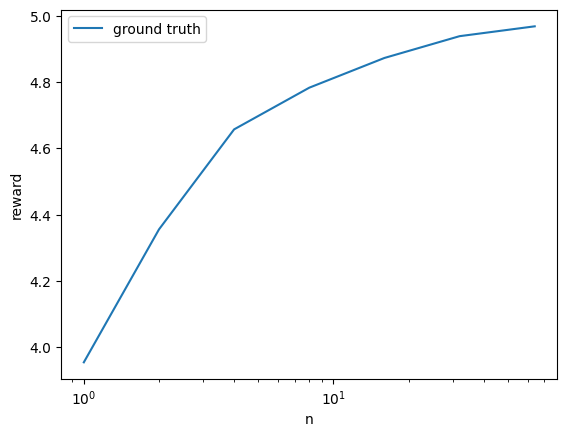

In [71]:
def estimate_reward(n:int, reward_model: Callable) -> float:
    rewards = []

    for _ in range(100):
        _, best_reward = best_of_n(n, reward_model)
        rewards.append(best_reward)

    return np.mean(rewards)

rewards_ground_truth: list[float] = []

RANGE_N: list[int] = [1, 2, 4, 8, 16, 32, 64]
for n in RANGE_N:
    reward_ground_truth: float = estimate_reward(n, reward_model_ground_truth)
    rewards_ground_truth.append(reward_ground_truth)

# Plot proxy vs. ground truth rewards
# With uniform random noise, the proxy as well as the ground truth reward are monotonically increasing
# But thats not the case when using a real instead of a toy reward model, see https://arxiv.org/pdf/2210.10760.pdf
plt.plot(RANGE_N, rewards_ground_truth)
plt.xscale('log')
plt.ylabel('reward')
plt.xlabel('n')
plt.legend(['ground truth'])
plt.show()

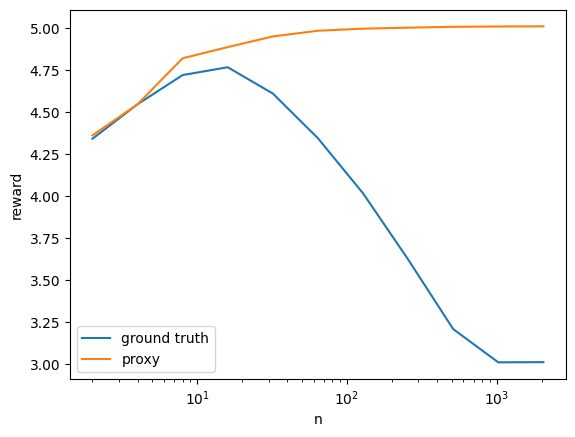

In [72]:
# why not using very large n?

def estimate_reward(n:int, reward_model: Callable) -> float:
    reward_proxy = []
    reward_ground_truth = []
    for _ in range(100):
        best_output, _ = best_of_n(n, reward_model)
        reward_proxy.append(reward_model_proxy(best_output))
        reward_ground_truth.append(reward_model_ground_truth(best_output))
    return np.mean(reward_proxy), np.mean(reward_ground_truth)

rewards_ground_truth: list[float] = []
rewards_proxy: list[float] = []

RANGE_N: list[int] = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
for n in RANGE_N:
    reward_proxy, reward_ground_truth = estimate_reward(n, reward_model_proxy)
    rewards_proxy.append(reward_proxy)
    rewards_ground_truth.append(reward_ground_truth)

# Plot proxy vs. ground truth rewards
# With uniform random noise, the proxy as well as the ground truth reward are monotonically increasing
# But thats not the case when using a real instead of a toy reward model, see https://arxiv.org/pdf/2210.10760.pdf
plt.plot(RANGE_N, rewards_ground_truth)
plt.plot(RANGE_N, rewards_proxy)
plt.xscale('log')
plt.ylabel('reward')
plt.xlabel('n')
plt.legend(['ground truth', 'proxy'])
plt.show()